# Описание проекта

В рамках проекта обработаем реальные сырые данне от одного из крупнейших маркетплейсов страны. 

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время. Предстоит выполнить инженеринг признаков, обучить и оптимизировать модель бинарной классификации, которая предскажет вероятность совершения покупки пользователем в течение 90 дней.

## Цель

Предсказать вероятность покупки в течение 90 дней

## Задачи

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

## Описание данных

**apparel-messages** история рекламных рассылок

Рассылки, которые были отправлены клиентам из таблицы покупок. 
- bulk_campaign_id идентификатор рассылки 
- client_id идентификатор клиента 
- message_id идентификатор сообщения 
- event действие с сообщением (отправлено, открыто, покупка…) 
- channel канал рассылки 
- date дата действия 
- created_at дата-время полностью 

**target** 
- client_id идентификатор клиента 
- target клиент совершил покупку в целевом периоде 

Общая база рассылок огромна, поэтому собрали для вас агрегированную по дням статистику по рассылкам. Если будете создавать на основе этой статистики дополнительные признаки, обратите внимание, что нельзя суммировать по колонкам nunique, потому что это уникальные клиенты в пределах дня, у вас нет данных, повторяются ли они в другие дни) 

**full_campaign_daily_event** 
Агрегация общей базы рассылок по дням и типам событий 
- date дата 
- bulk_campaign_id идентификатор рассылки
- count_event_channel* общее количество каждого события 
- nunique_event_channel* количество уникальных client_id в каждом событии 

*в именах колонок найдете все типы событий event 

**full_campaign_daily_event_channel** 
Агрегация по дням с учетом событий и каналов рассылки 
- date дата 
- bulk_campaign_id идентификатор рассылки 
- count_event*_channel* общее количество каждого события по каналам
- nunique_event*_channel* количество уникальных client_id по событиям и каналам 

*в именах колонок есть все типы событий event и каналов рассылки channel

## Ход исследования

**Что важно учесть при выполнении проекта**

Как известно данные не идельны. Во время загрузки, преоразования из одного формата в другой могут возникнуть технологические 
ошибки. Так же во время наполнения базы объявлений сотрудники могли допустить различные опечатки, либо перепутать переменные в столбцах, ведь человеческий фактор присутствует в любой сфере. Поэтому для качественного выполнения проекта необходимо основательно сделать предобработку данных и обратить внимание на следующие моменты:

1. описать найденные в данных проблемы,
2. применить различные методы: замену типов данных, обработку пропусков случайных, неслучайных и полностью случайных, обработку явных и не явных дубликатов,
3. использовать категоризацию данных,
4. применить четкую  структуру проекта и придерживаться хорошего стиля при написании кода,
5. обозначить выводы по этапам,
6. кратко комментировать шаги,
7. использовать срезы данных,
8. построить графики для решения задич,
9. использовать различные методы построения графиков,
10. использовать сводные таблицы для вывода данных,
11. объяснить, как коррелируют между собой различные величины или показатели. 


# Исследовательский анализ данных

Исследовательский анализ данных (Exploratory Data Analysis, EDA) — является важным этапом, который позволяет лучше понять данные и выявить основные характеристики и закономерности. Все выявленные проблемы на данном этапе будут исправлены в шаге предобработки данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    recall_score, 
    precision_score,
    precision_recall_curve,
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import warnings
import optuna
import random
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# вывод всех столбцов и строк, независимо от их количества.
pd.set_option('display.max_columns', None)

# отключаем предупреждение
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
purchases = pd.read_csv(
        '.../apparel-purchases.csv'
)
messages = pd.read_csv(
        '.../apparel-messages.csv'
)
data = pd.read_csv(
        '.../apparel-target_binary.csv'
)
daily_event = pd.read_csv(
        '.../full_campaign_daily_event.csv'
)
event_channel = pd.read_csv(
        '.../full_campaign_daily_event_channel.csv'
)

In [3]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [4]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [5]:
data.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [6]:
daily_event.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [7]:
event_channel.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Соответствие техническому описанию

Заказчик предоставил данные с признаками:

apparel_purchases - история покупок.

- client_id идентификатор клиента 
- quantity количество единиц товара
- price цена товара 
- category_ids идентификаторы категорий 
- date дата покупки 
- message_id идентификатор сообщения из рассылки

In [8]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


apparel-messages - история рекламных рассылок. Рассылки, которые были отправлены клиентам из таблицы покупок. 

- bulk_campaign_id идентификатор рассылки 
- client_id идентификатор клиента 
- message_id идентификатор сообщения 
- event действие с сообщением (отправлено, открыто, покупка…) 
- channel канал рассылки 
- date дата действия 
- created_at дата-время полностью 

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


target - целевой признак

- client_id идентификатор клиента 
- target клиент совершил покупку в целевом периоде 

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


full_campaign_daily_event Агрегация общей базы рассылок по дням и типам событий 

- date дата 
- bulk_campaign_id идентификатор рассылки
- count_event_channel* общее количество каждого события 
- nunique_event_channel* количество уникальных client_id в каждом событии 

In [11]:
daily_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

full_campaign_daily_event_channel Агрегация по дням с учетом событий и каналов рассылки 

- date дата 
- bulk_campaign_id идентификатор рассылки 
- count_event*_channel* общее количество каждого события по каналам
- nunique_event*_channel* количество уникальных client_id по событиям и каналам

In [12]:
event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

Таблицы соответствуют техническому описанию, пропуски отсутствуют.

## Новые признаки

Основным датафреймом для обучения моделей будет **data**. Создадим в нем новые признаки, на основе других фреймов:

- total_quantity — количество товаров
- total_spent — сумма по чекам 
- mean_spent — средня сумма по чекам 
- message_count	— количество сообщений клиенту
- open_count — количество открытых сообщений
- click_count — количество кликов
- send_count — количество отправленных сообщений
- most_frequent_channel — самый частый канал взаимодействия с клиентом

In [13]:
def create_features(data, purchases, messages):
    # Создание признака уровня вложенности
    purchases['category_depth'] = purchases['category_ids'].apply(len)

    # Признаки из purchases
    purchases_agg = purchases.groupby('client_id').agg(
        total_quantity=('quantity', 'sum'),
        total_spent=('price', 'sum'),
        mean_spent=('price', 'mean'),
        mean_len_cat=('category_depth', 'mean')
    ).reset_index()

    # Признаки из messages
    messages_agg = messages.groupby('client_id').agg(
        message_count=('message_id', 'count'),
        open_count=('event', lambda x: (x == 'open').sum()),
        click_count=('event', lambda x: (x == 'click').sum()),
        send_count=('event', lambda x: (x == 'send').sum())
    ).reset_index()

    # Признак наиболее частого канала
    most_frequent_channel = messages.groupby('client_id')['channel'].agg(
        most_frequent_channel=lambda x: x.mode()[0] if not x.mode().empty else None
    ).reset_index()

    # Объединяем все признаки в target
    data = data.merge(purchases_agg, on='client_id', how='left')
    data = data.merge(messages_agg, on='client_id', how='left')
    data = data.merge(most_frequent_channel, on='client_id', how='left')

    # Заполняем NaN значениями нулями или unknown
    data = data.apply(
        lambda x: x.fillna(0) if x.dtype in ['int64', 'float64'] else x.fillna('unknown')
    )
    
    return data

In [14]:
data = create_features(data, purchases, messages)

## Статистический анализ

In [15]:
# data
(
    data
    .drop('client_id', axis=1)
    .select_dtypes(include='number')
    .describe()
    .style.format('{:,.2f}')
)

,target,total_quantity,total_spent,mean_spent,mean_len_cat,message_count,open_count,click_count,send_count
count,"49,849.00","49,849.00","49,849.00","49,849.00","49,849.00","49,849.00","49,849.00","49,849.00","49,849.00"
mean,0.02,4.08,"4,840.52","1,483.42",25.93,219.68,50.34,9.14,158.46
std,0.14,5.56,"7,312.87","1,388.18",3.47,175.00,72.13,13.59,118.02
min,0.00,1.00,1.00,1.00,2.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,"1,499.00",699.00,25.00,81.00,0.00,1.00,59.00
50%,0.00,2.00,"2,929.00","1,249.00",25.00,200.00,15.00,5.00,151.00
75%,0.00,5.00,"5,677.00","1,999.00",27.00,322.00,77.00,12.00,243.00
max,1.00,355.00,"540,408.00","53,499.00",32.00,"3,100.00","1,268.00",384.00,"2,473.00"


In [16]:
# purchases
(
    purchases
    .drop('client_id', axis=1)
    .select_dtypes(include='number')
    .describe()
    .style.format('{:,.2f}')
)

,quantity,price,category_depth
count,"202,208.00","202,208.00","202,208.00"
mean,1.01,"1,193.30",26.00
std,0.18,"1,342.25",5.30
min,1.00,1.00,2.00
25%,1.00,352.00,25.00
50%,1.00,987.00,25.00
75%,1.00,"1,699.00",31.00
max,30.00,"85,499.00",32.00


In [17]:
# daily_event
(
    daily_event
    .drop('bulk_campaign_id', axis=1)
    .select_dtypes(include='number')
    .describe()
    .style.format('{:,.2f}')
)

,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,"131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00"
mean,90.98,0.93,78.47,"3,771.09",0.58,"11,634.14",27.81,0.14,6.36,74.28,0.92,77.40,"3,683.00",0.47,"11,537.16",27.57,0.13,5.96,0.81,0.81,0.00,0.00
std,"1,275.50",30.20,"1,961.32","65,160.67",9.11,"175,709.51",736.94,2.07,79.17,"1,004.27",29.72,"1,913.40","62,586.47",7.13,"172,700.49",734.05,1.98,73.28,183.30,183.30,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2.00,0.00,0.00,30.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,30.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
max,"128,453.00","5,160.00","287,404.00","5,076,151.00","1,077.00","11,543,513.00","76,284.00",189.00,"9,089.00","75,899.00","5,043.00","287,341.00","2,922,440.00",779.00,"7,094,600.00","76,281.00",177.00,"8,299.00","63,920.00","63,920.00",1.00,1.00


In [18]:
# event_channel
(
    event_channel
    .drop('bulk_campaign_id', axis=1)
    .select_dtypes(include='number')
    .describe()
    .style.format('{:,.2f}')
)

,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,"131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00","131,072.00"
mean,41.58,49.40,423.71,"3,347.38",0.36,0.22,24.47,0.14,6.36,31.40,42.88,411.66,"3,271.34",0.29,0.18,24.26,0.13,5.96,59.48,"7,444.56",58.86,"7,350.27",18.99,0.81,"4,189.58",18.54,0.81,"4,186.90",3.33,3.31,0.93,0.92,0.00,0.00
std,745.48,"1,036.95","9,753.38","64,448.59",8.29,3.80,727.07,2.07,79.17,562.88,833.32,"9,519.71","61,880.01",6.48,2.97,724.27,1.98,73.28,"1,371.96","139,350.92","1,357.27","135,579.92","1,402.41",183.30,"107,319.76","1,349.47",183.30,"107,261.80",120.92,120.09,30.20,29.72,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,"59,365.00","128,453.00","2,597,015.00","5,076,151.00","1,077.00",431.00,"76,284.00",189.00,"9,089.00","45,718.00","75,899.00","2,548,617.00","2,922,440.00",779.00,359.00,"76,281.00",177.00,"8,299.00","165,526.00","11,543,513.00","165,526.00","6,636,578.00","287,404.00","63,920.00","7,094,600.00","287,341.00","63,920.00","7,094,600.00","21,831.00","21,389.00","5,160.00","5,043.00",1.00,1.00


## Визуализация

### Количественные признаки

In [19]:
def hist_box_num_sub(categ, data, x, hue, title_hist, xlabel, ylabel, **kwargs):
    """
    categ - уникальные значения из любого категориального признака, по количеству которых будут определены цвета
    data - датафрейм
    x - ость, по которой распределяются значения количественного признака
    hue - семантическая переменная, которая сопоставляется для определения цвета элементов графика.
    title_hist - название гистограммы
    xlabel, ylabel - название осей
    **kwargs:
     - rotation=90 - угол поворота надписей по оси х
     - fig_size=(17, 4) - размер графиков
     - x_range=(0, 30) - ограничение диапазона по оси х
    Переменные categ и hue должны совпадать по количеству уникальных значений, так как палитра цветов строится на основе этого значения 
    """
    # создаем случайные цвета
    def random_color():
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # уникальные категории
    categories = categ

    # случайные цвета для каждой категории
    colors_hist = {cat: random_color() for cat in categories}
    colors_box = {cat: random_color() for cat in categories}
	
	# вертикальные линии
    mean = np.mean(data[x])
    median = np.median(data[x])
    
    # Инициализация объекта Figure и создания подграфиков
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # определяем верхнюю границу по оси Y на основе данных
    y_max = axes[0].get_ylim()[1] * 1 # можем адаптировать множитель

    # Установка диапазона по оси x, если задан
    if 'x_range' in kwargs:
        axes[0].set_xlim(kwargs['x_range'])
        axes[1].set_xlim(kwargs['x_range'])
    
    sns.histplot(data=data, 
                 x=x, 
                 hue=hue,
                 palette=colors_hist,
                 ax=axes[0], 
                 kde=True,
                 multiple='stack',
                 legend=True
                )
    axes[0].vlines(mean, 0, y_max, color='red', label='Среднее')
    axes[0].vlines(median, 0, y_max, color='blue', linestyle='--', label='Медиана')
    axes[0].set_title(title_hist,  fontsize=9)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    # axes[0].legend(title=title_hist, loc='upper left')
    
    sns.boxplot(data=data, 
                x=x, 
                hue=hue,
                palette=colors_box,
                ax=axes[1]
               )
    axes[1].set_title('Ящик с усами количественного признака',  fontsize=9)
    axes[1].set_xlabel(xlabel)
    axes[1].legend(title=hue, loc='upper left')
    plt.tight_layout()
    plt.show()

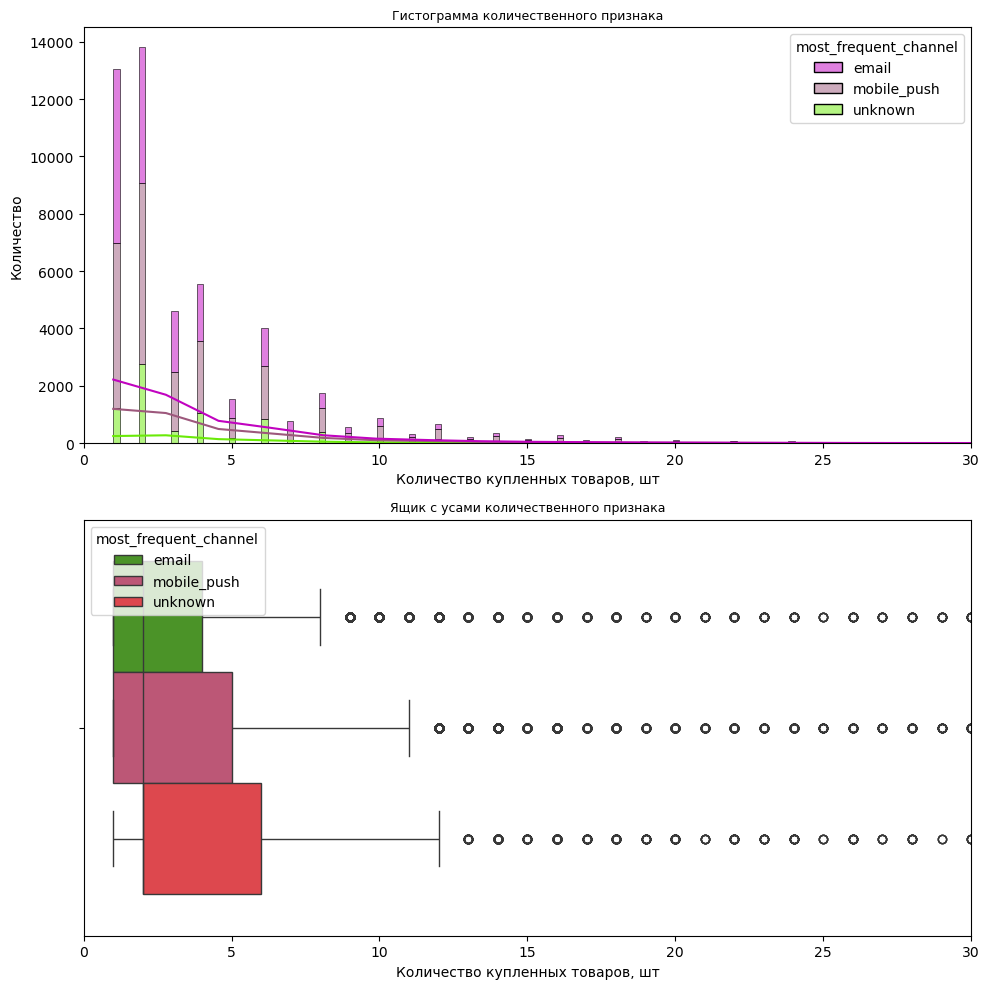

In [20]:
# total_quantity
hist_box_num_sub(
    data.most_frequent_channel.unique(),
    data, 
    'total_quantity', 
    'most_frequent_channel',
    'Гистограмма количественного признака', 
    'Количество купленных товаров, шт', 
    'Количество',
    x_range=(0, 30)
)

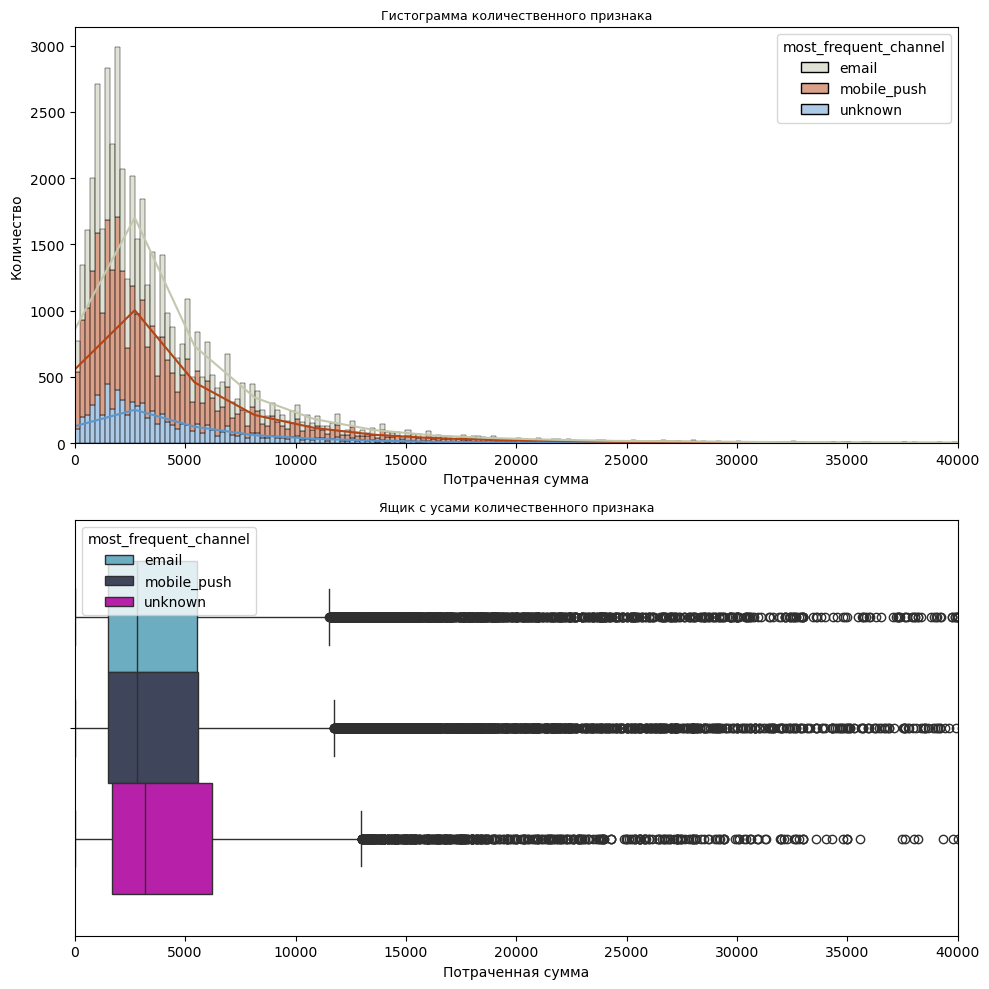

In [21]:
# total_spent
hist_box_num_sub(
    data.most_frequent_channel.unique(),
    data, 
    'total_spent', 
    'most_frequent_channel',
    'Гистограмма количественного признака', 
    'Потраченная сумма', 
    'Количество',
    x_range=(0, 40000)
)

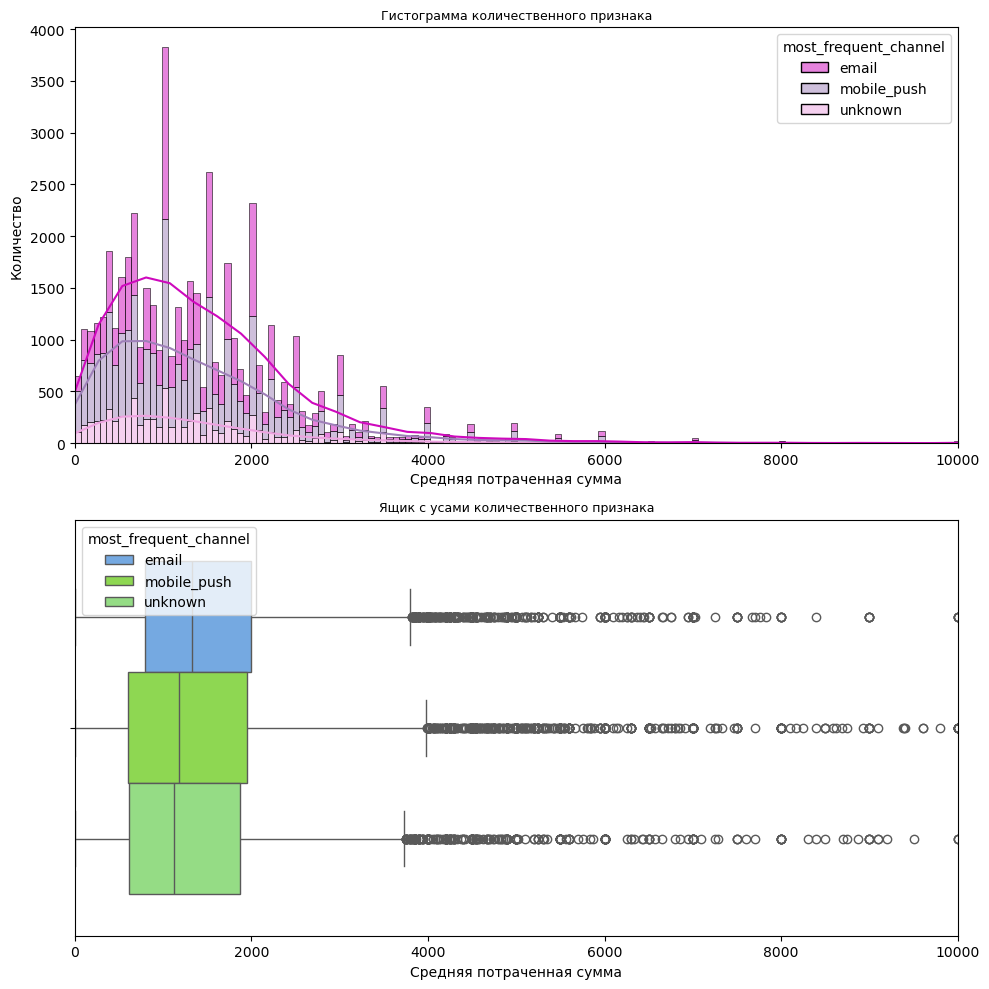

In [22]:
# mean_spent
hist_box_num_sub(
    data.most_frequent_channel.unique(),
    data, 
    'mean_spent', 
    'most_frequent_channel',
    'Гистограмма количественного признака', 
    'Средняя потраченная сумма', 
    'Количество',
    x_range=(0, 10000)
)

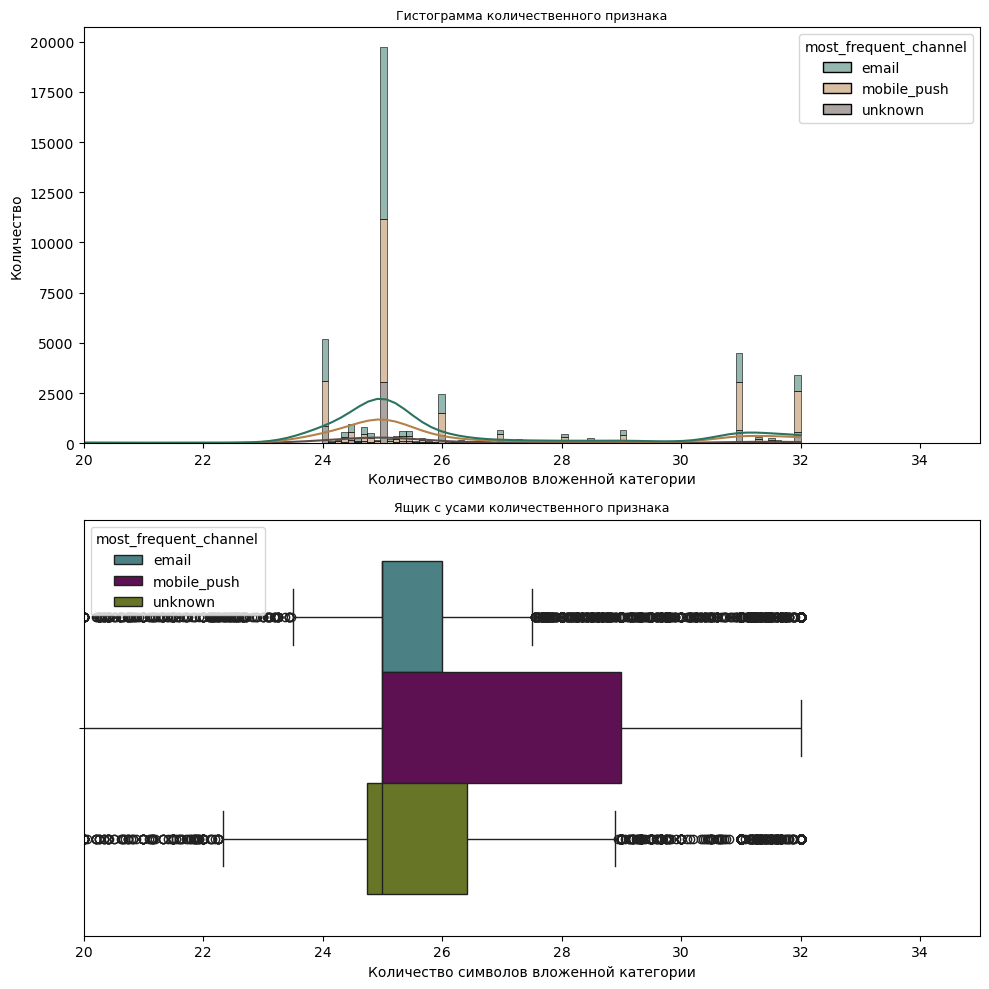

In [23]:
# mean_len_cat
hist_box_num_sub(
    data.most_frequent_channel.unique(),
    data, 
    'mean_len_cat', 
    'most_frequent_channel',
    'Гистограмма количественного признака', 
    'Количество символов вложенной категории', 
    'Количество',
    x_range=(20, 35)
)

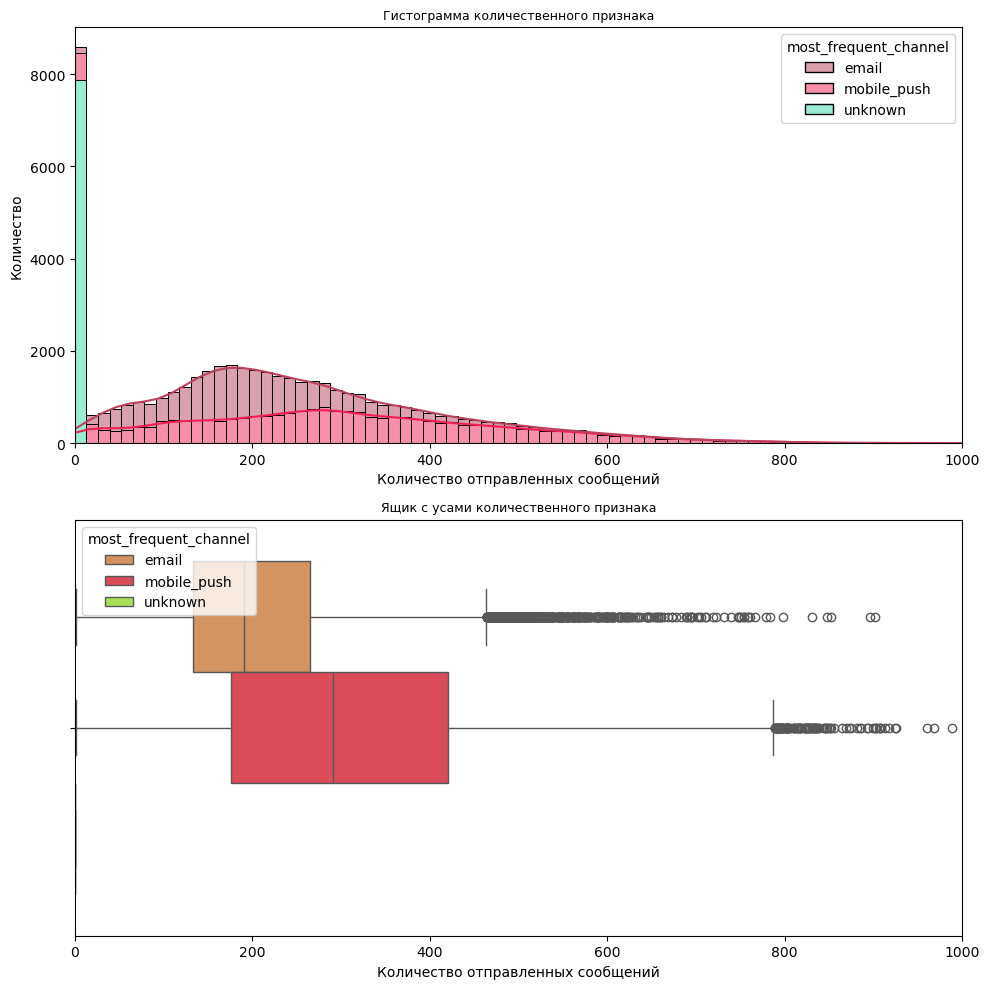

In [24]:
# message_count
hist_box_num_sub(
    data.most_frequent_channel.unique(),
    data, 
    'message_count', 
    'most_frequent_channel',
    'Гистограмма количественного признака', 
    'Количество отправленных сообщений', 
    'Количество',
    x_range=(0, 1000)
)

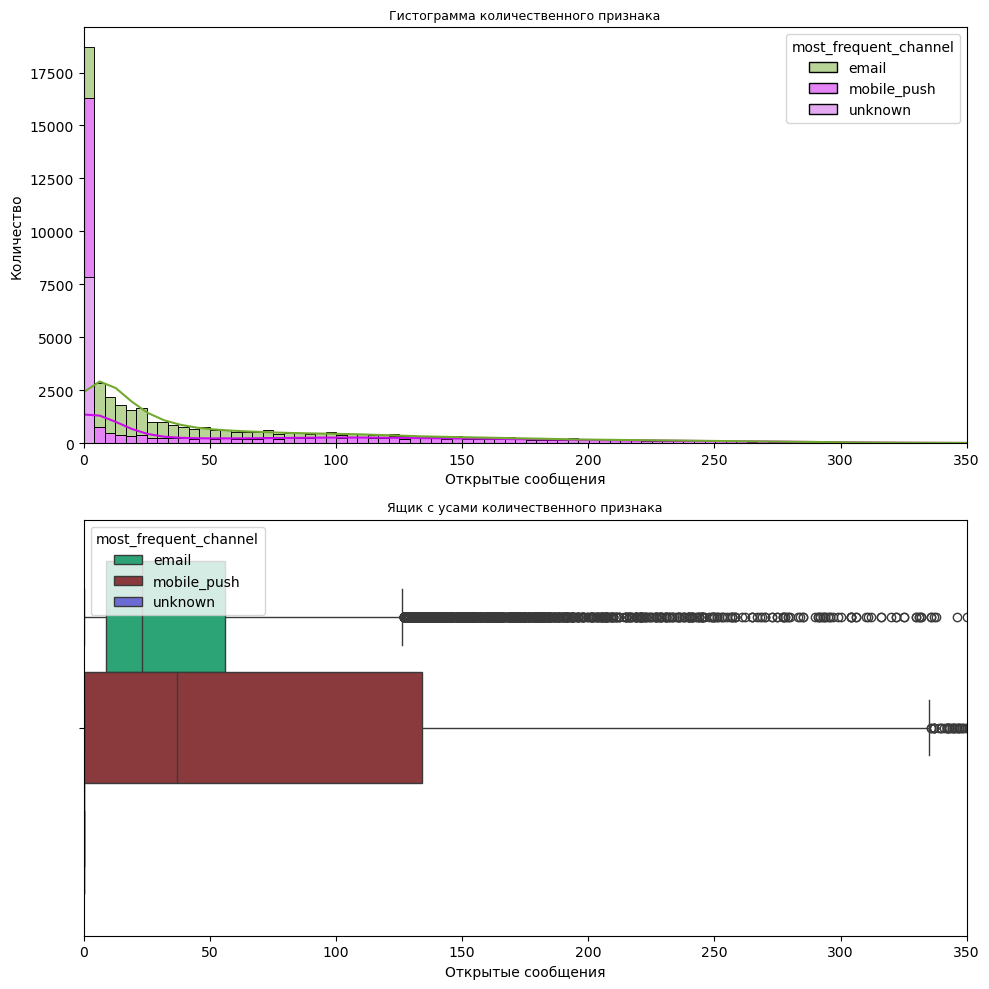

In [25]:
# open_count
hist_box_num_sub(
    data.most_frequent_channel.unique(),
    data, 
    'open_count', 
    'most_frequent_channel',
    'Гистограмма количественного признака', 
    'Открытые сообщения', 
    'Количество',
    x_range=(0, 350)
)

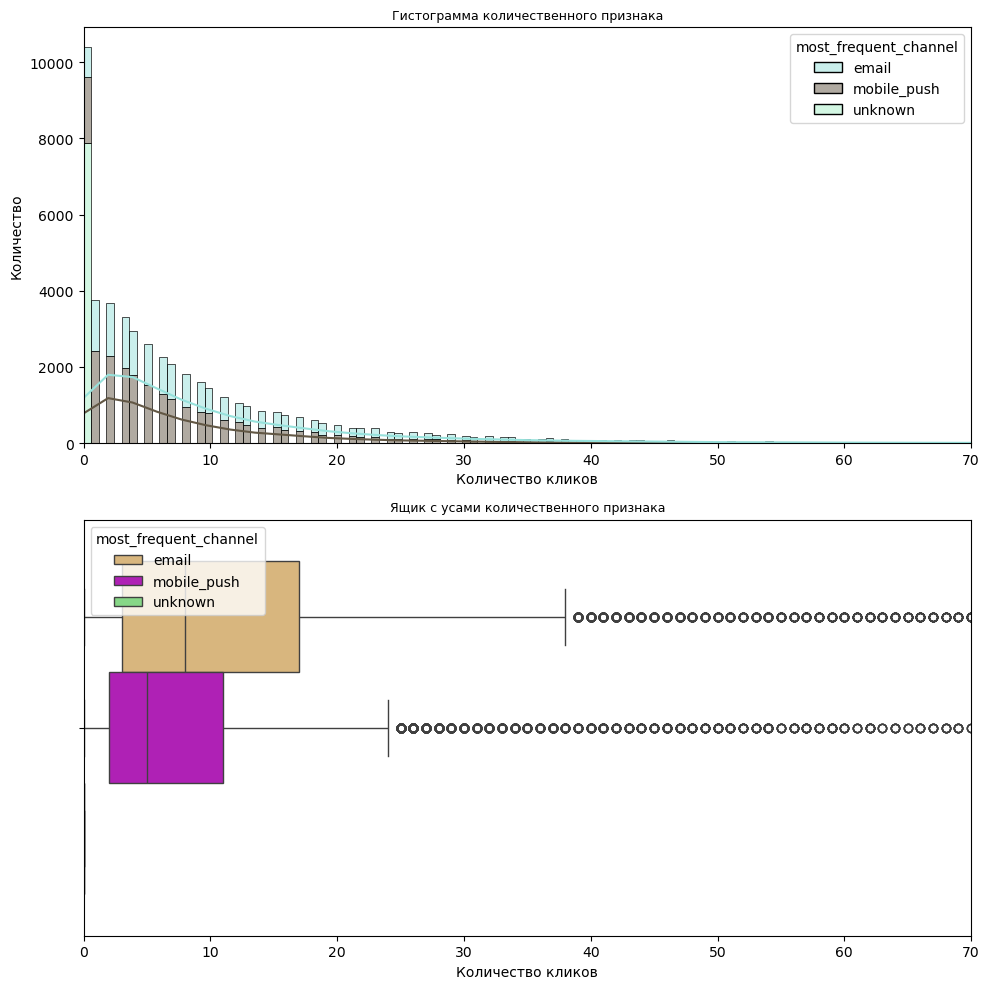

In [26]:
# click_count
hist_box_num_sub(
    data.most_frequent_channel.unique(),
    data, 
    'click_count', 
    'most_frequent_channel',
    'Гистограмма количественного признака', 
    'Количество кликов', 
    'Количество',
    x_range=(0, 70)
)

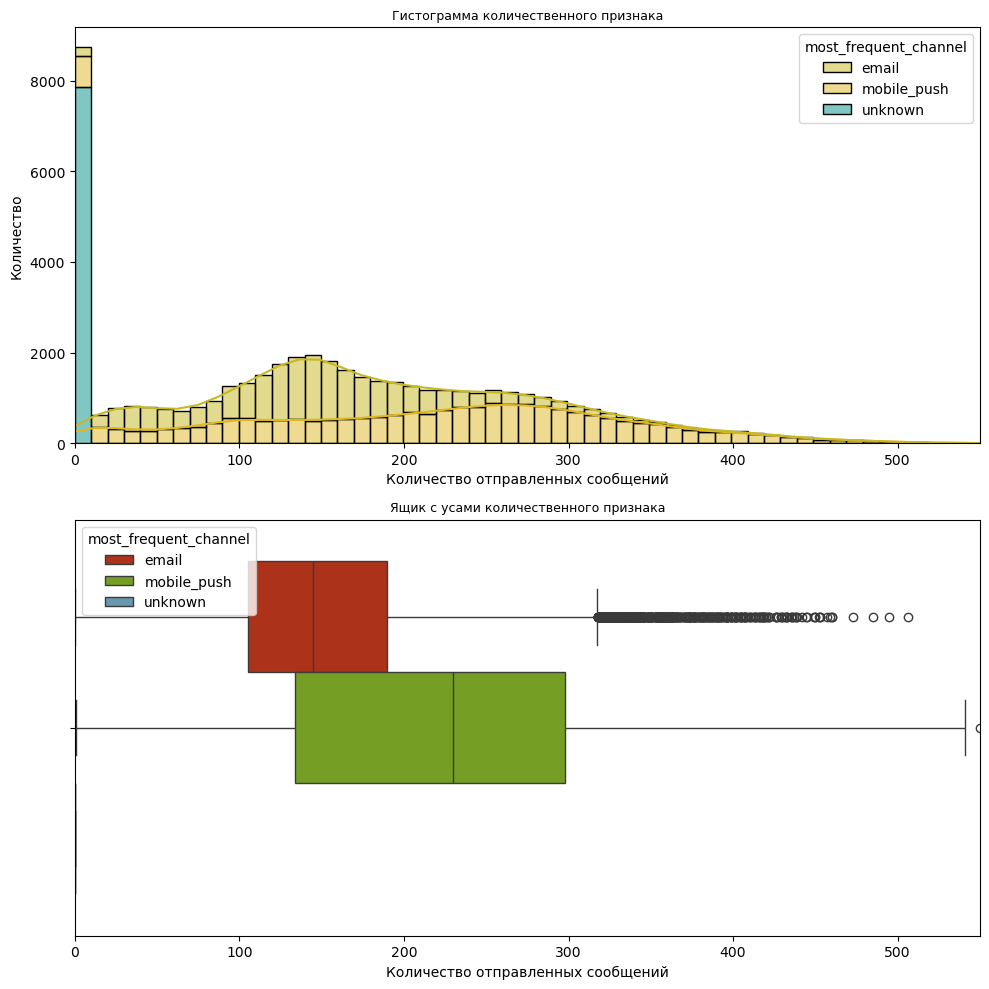

In [27]:
# send_count
hist_box_num_sub(
    data.most_frequent_channel.unique(),
    data, 
    'send_count', 
    'most_frequent_channel',
    'Гистограмма количественного признака', 
    'Количество отправленных сообщений', 
    'Количество',
    x_range=(0, 550)
)

У всех признаков присутствуют выбросы

### Категориальные признаки

In [28]:
def hist_countolot(data, x, xlabel):

    # создаем случайные цвета
    def random_color():
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # уникальные категории
    categories = data.target.unique()

    # случайные цвета для каждой категории
    colors_hist = {cat: random_color() for cat in categories}

    # гистограмма
    plt.figure(figsize=(10, 4))
    ax = sns.countplot(
        data,
        x=x, 
        palette=colors_hist,
        hue='target', 
        stat='percent'
    )
    ax.set_title('График распределения категориального признака',  fontsize=9)

    
    # Настраиваем ось Y для отображения целых чисел
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # plt.title('График распределения категориального признака',  fontsize=9)
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.legend(title='Уровень занимаемой должности', loc='upper right')
    plt.show()

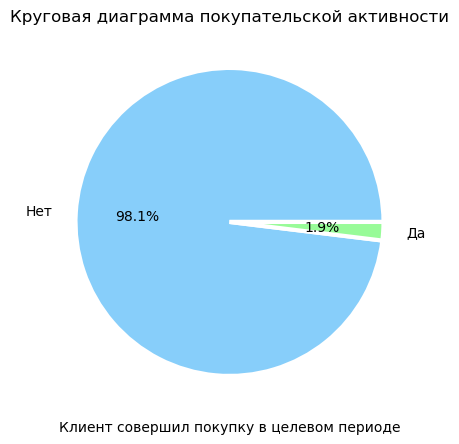

In [29]:
# target
plt.rcParams["figure.figsize"] = (25,5)
fig, ax = plt.subplots()
ax.pie(data.target.value_counts(), 
       labels=('Нет', 'Да'),
       autopct='%1.1f%%', labeldistance=1.15,
       wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
       colors=['lightskyblue', 'palegreen'])
plt.xlabel('Клиент совершил покупку в целевом периоде')
plt.title('Круговая диаграмма покупательской активности')
plt.show()

В целевом признаке присутствует явный дисбаланс в сторону минорного класса. Необходимо учесть это при обучении моделей и использовать стратификацию 

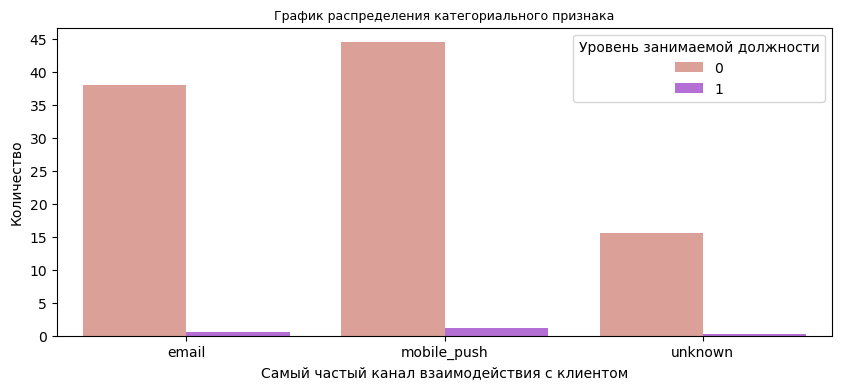

In [30]:
# most_frequent_channel
hist_countolot(
    data, 
    'most_frequent_channel', 
    'Самый частый канал взаимодействия с клиентом'
) 

### Корреляционный анализ

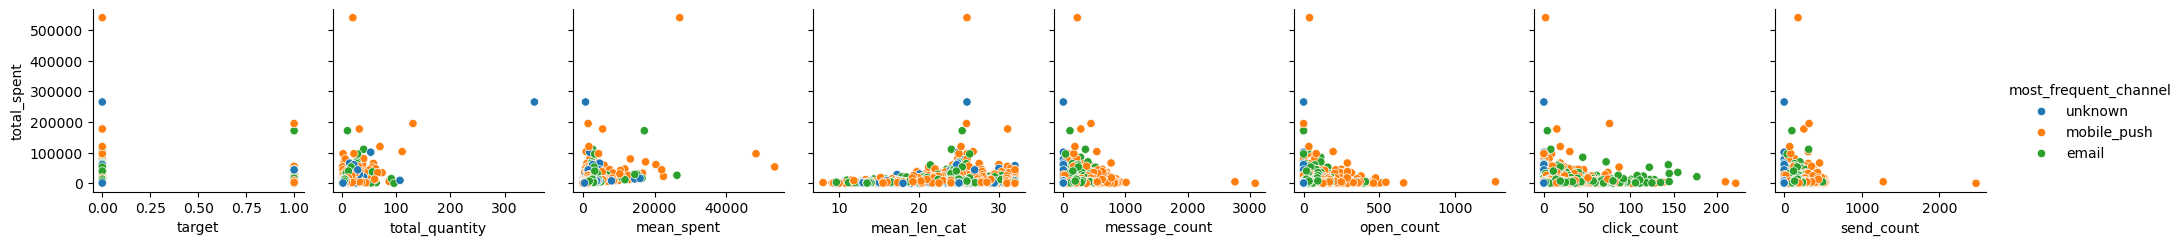

In [31]:
cat = ['most_frequent_channel']
for category in cat:
    g = sns.PairGrid(
        data.sample(frac=0.3, random_state=42), 
        hue=category, 
        x_vars=(
            data
            .select_dtypes(include='number')
            .drop(['client_id', 'total_spent'], axis=1)
            .columns
        ),
        y_vars='total_spent'
    )
    g.map(sns.scatterplot)
    g.add_legend()
    plt.show()

На диаграммах рассеяния нет четкой тенденции распределения данных.

In [32]:
# считаем корреляцию
phik_overview = phik_matrix(
    data,
    interval_cols=(
        data
        .select_dtypes(include='number')
        .columns
    ) 
)

# размер матрицы
phik_overview.shape

(11, 11)

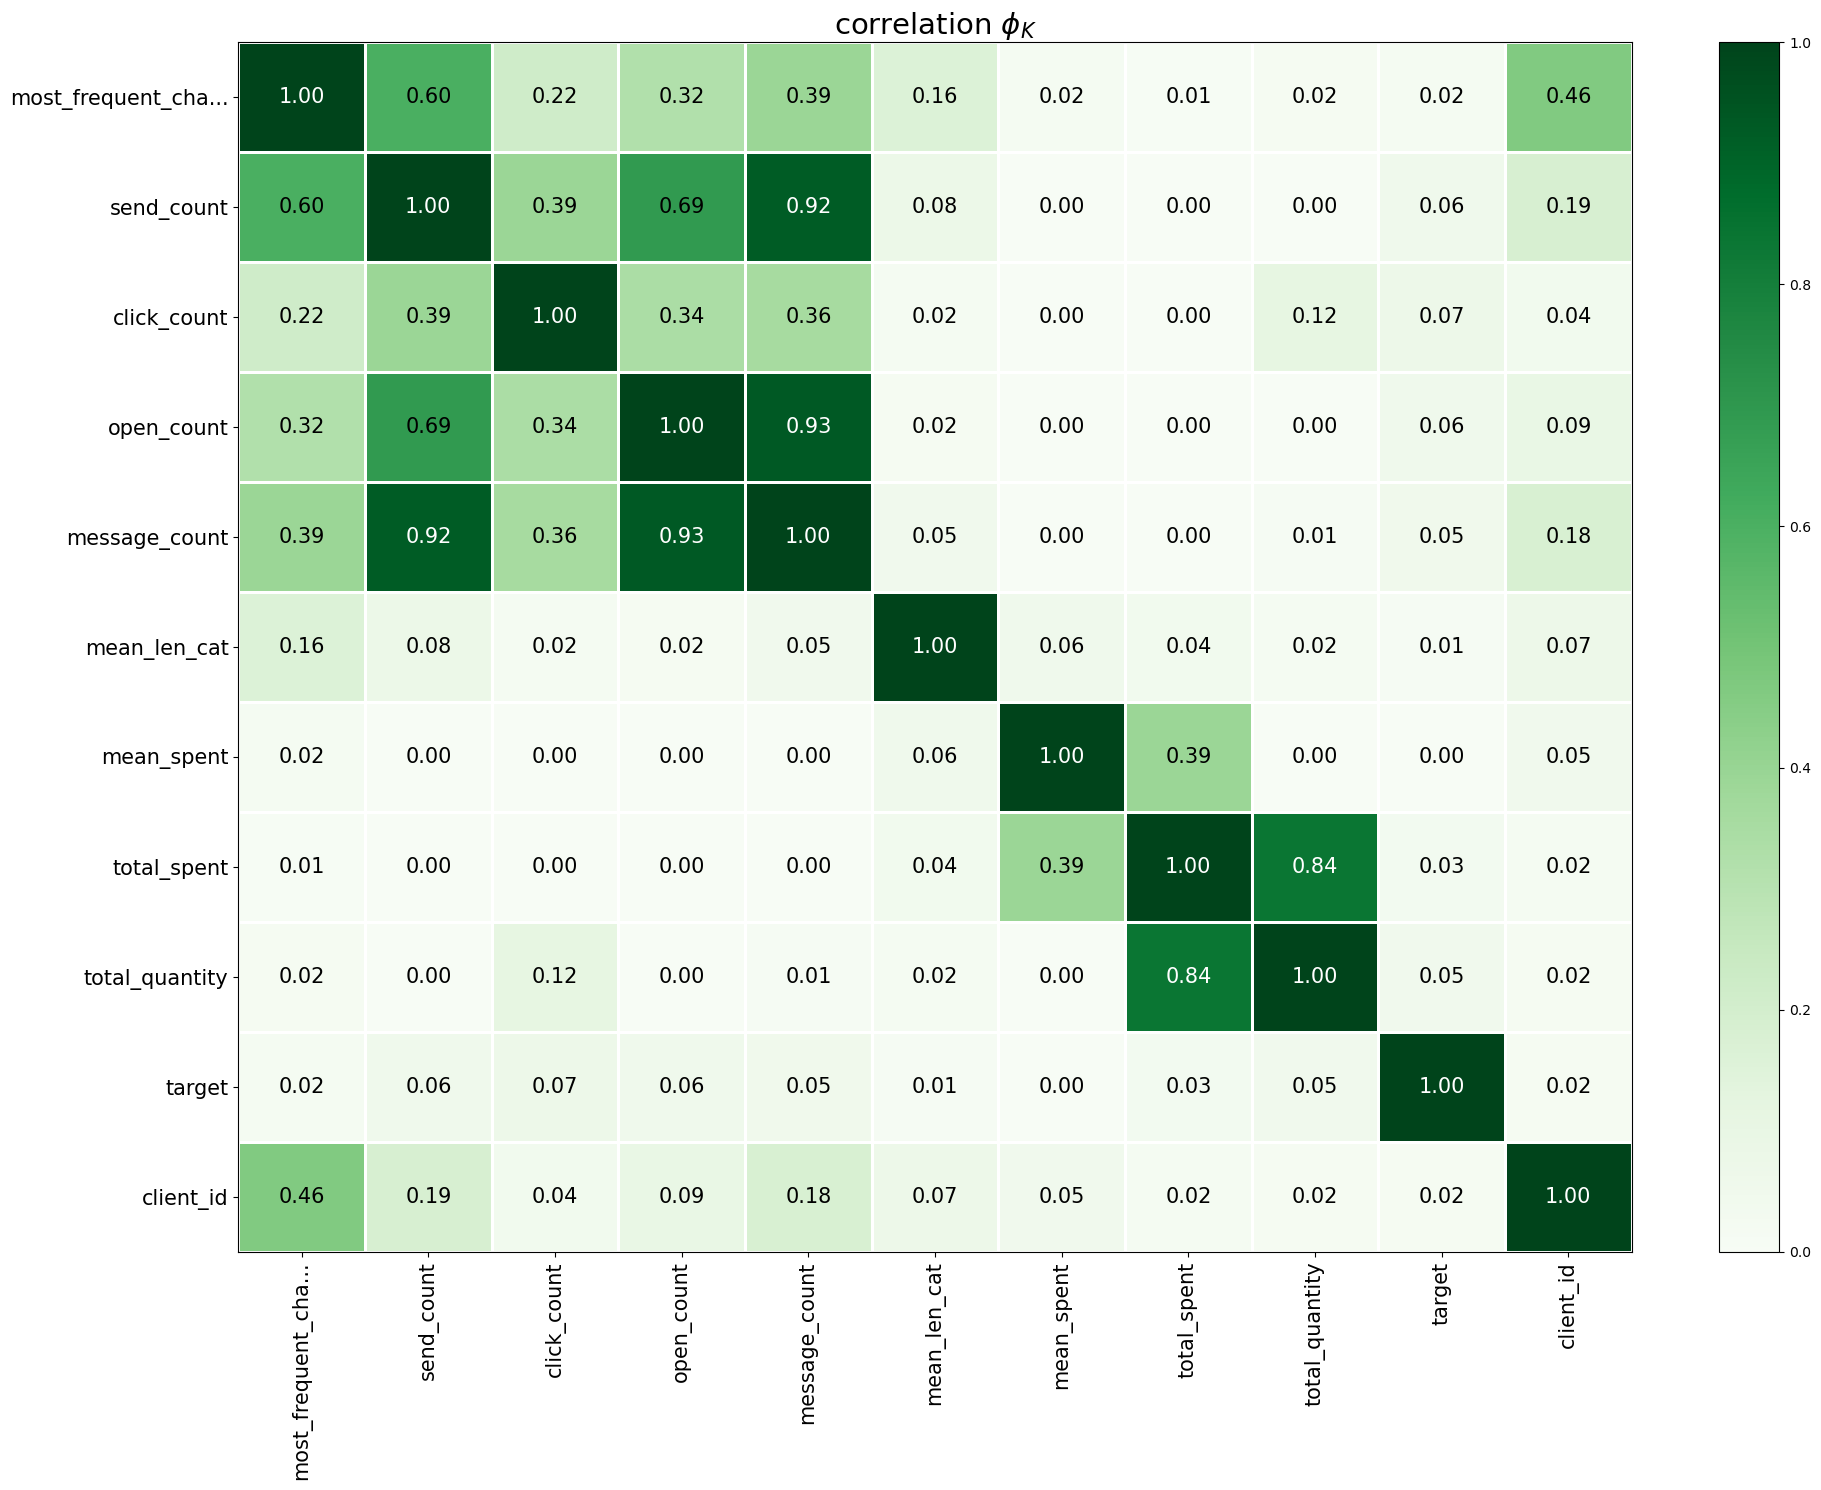

In [33]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

После построение корреляционной матрицы входящих признаков к целевому можно сделать следующие выводы:

- зеленые тона говорят о сильной линейной зависимости, а светлые — о слабой;
- корреляция между целевым и остальными достаточно очень слабая;
- мультикорреляция присутствует между парами **send_count -> message_count**, **open_count -> message_count**, так как порог для подтверждения 0.9-0.95;
- утечки целевого признака через входящие не наблюдается.
- исключим из обучения признак **message_count**

# Предобработка данных

Подготовка данных для анализа называется предобработкой. Нужно оценить масштаб найденных проблем и устранить их. Предобработка следует принципу GIGO (от англ. garbage in — garbage out, буквально «мусор на входе — мусор на выходе»). Это значит, что при ошибках во входных данных даже правильный алгоритм работы приведёт к неверным результатам. Так же нужно помнить об законе экономии, который называется Бри́тва О́ккама. В нем говорится следующее: Не следует множить сущее без необходимости. Суть принципа: совершенство должно быть простым. Если какого-то результата можно достичь с привлечением сущностей A, B и C либо другим путём с привлечением A, B, С и D — надо выбирать первый путь. В плане программирования это значит, что не следут создавать промежуточные переменные, которые не пригодяться в дальнейшем.

Фильтруем выбросы с помощью кастомного трансформера с порогом для каждого признака, так жк исключим **message_count**

In [34]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, thresholds={
            'total_quantity': 1.5, 'total_spent': 1.5, 'mean_spent': 1.5, 'mean_len_cat': 1.5,
            'open_count': 1.5, 'click_count': 1.5, 'send_count': 1.5
    }
                ):
        self.thresholds = thresholds

    def fit(self, X, y=None):
        # Сохраним медианы для замены выбросов
        self.median_total_quantity = X['total_quantity'].median()  
        self.median_total_spent = X['total_spent'].median()  
        self.median_mean_spent = X['mean_spent'].median()
        self.median_mean_len_cat = X['mean_len_cat'].median() 
        self.median_open_count = X['open_count'].median()  
        self.median_click_count = X['click_count'].median()
        self.median_send_count = X['send_count'].median() 
        return self

    def transform(self, X):
        X_len_stock = X.shape[0]
        X = X.drop('message_count', axis=1)

        # Числовые признаки
        # Создадим DataFrame для хранения границ выбросов
        outlier_info = pd.DataFrame(columns=['Feature', 'Threshold', 'Lower Bound', 'Upper Bound'])
        
        # Убрать выбросы (аномалии) из количественных признаков
        for column in [
            'total_quantity', 'total_spent', 'mean_spent', 'mean_len_cat', 
            'open_count', 'click_count', 'send_count']:
            thresholds = self.thresholds[column]
            lower_bound = (
                X[column].quantile(0.25) * thresholds # - thresholds * (X[column].quantile(0.75) - X[column].quantile(0.25))
            )
            upper_bound = (
                X[column].quantile(0.75) + thresholds * (X[column].quantile(0.75) - X[column].quantile(0.25))
            )

            # Добавляем информацию о выбросах в DataFrame
            outlier_info = pd.concat([
                outlier_info,
                pd.DataFrame([{
                    'Feature': column,
                    'Threshold': thresholds,
                    'Lower Bound': lower_bound,
                    'Upper Bound': upper_bound
                }])
            ], ignore_index=True)

            median_value = {
                'total_quantity': self.median_total_quantity,
                'total_spent': self.median_total_spent,
                'mean_spent': self.median_mean_spent,
                'mean_len_cat': self.median_mean_len_cat,
                'open_count': self.median_open_count,
                'click_count': self.median_click_count,
                'send_count': self.median_send_count
            }.get(column, None)
            X[column] = np.where((X[column] < lower_bound) | (X[column] > upper_bound), median_value, X[column])
                
        # Выводим таблицу с информацией о выбросах
        display(outlier_info.set_index('Feature').T)

        return X

In [35]:
pipe_pre = Pipeline(
    [
        ('custom_transformer', CustomTransformer(thresholds={
            'total_quantity': 1, 'total_spent': 1, 'mean_spent': 1, 'mean_len_cat': 1,
            'open_count': 0.25, 'click_count': 1, 'send_count': 1
            }))
    ]
)
data_pre = pipe_pre.fit_transform(data)

Feature,total_quantity,total_spent,mean_spent,mean_len_cat,open_count,click_count,send_count
Threshold,1,1,1,1,0.25,1,1
Lower Bound,1.0,1499.0,699.0,25.0,0.0,1.0,59.0
Upper Bound,9.0,9855.0,3299.0,29.0,96.25,23.0,427.0


## Обучение модели

In [36]:
le = LabelEncoder()
data['most_frequent_channel'] = le.fit_transform(data['most_frequent_channel'])

In [37]:
RANDOM_STATE = 42 
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = (
    train_test_split(
        data.drop(['client_id', 'target'], axis=1),
        data.target,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE
    )
)

In [38]:
# Функция для оптимизации гиперпараметров
def objective(trial):
    # Определяем гиперпараметры
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
    }

    # Создаем модель
    model = LGBMClassifier(**param)

    # Оцениваем модель с помощью кросс-валидации
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return score

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Выводим лучшие гиперпараметры
print("Best hyperparameters: ", study.best_params)
print("Best ROC AUC: ", study.best_value)

Best hyperparameters:  {'boosting_type': 'gbdt', 'num_leaves': 90, 'learning_rate': 0.018582943362230982, 'scale_pos_weight': 4.957563917806114, 'max_depth': 4, 'min_child_samples': 13}
Best ROC AUC:  0.7083215206835516


In [39]:
# Обучим модель на лучших параметрах
best_lgbm = LGBMClassifier(**study.best_params)
best_lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.018582943362230982, max_depth=4,
               min_child_samples=13, num_leaves=90,
               scale_pos_weight=4.957563917806114)

In [40]:
# Таблица с учетом порогов precision
y_proba = best_lgbm.predict_proba(X_test)[:,1]
data_pre = pd.DataFrame(zip(y_test, y_proba),
                    columns = ['y_test', 'y_proba']).sort_values(by='y_test', ascending=False)

# пороги
thresholds = [round(i,2) for i in np.linspace(0.1, 1, num = 10, endpoint=False)]

prec_score = []
for i in thresholds:
    result = precision_score(data_pre['y_test'],
                     (best_lgbm.predict_proba(X_test)[:,1] >= i).astype(int),
                    zero_division=1.0
                   )
    prec_score.append(result)

# Добавим столбцы с порогами
columns = []
for i in thresholds:
	columns.append('y_pred_'+str(i))
	data_pre['y_pred_'+str(i)] = data_pre['y_proba'].apply(
        lambda x: 1 if x >= i else 0)
    
data_pre.head()

,y_test,y_proba,y_pred_0.1,y_pred_0.19,y_pred_0.28,y_pred_0.37,y_pred_0.46,y_pred_0.55,y_pred_0.64,y_pred_0.73,y_pred_0.82,y_pred_0.91
8860,1,0.193969,1,1,0,0,0,0,0,0,0,0
224,1,0.171249,1,0,0,0,0,0,0,0,0,0
1165,1,0.088467,0,0,0,0,0,0,0,0,0,0
8795,1,0.099957,0,0,0,0,0,0,0,0,0,0
11447,1,0.054991,0,0,0,0,0,0,0,0,0,0


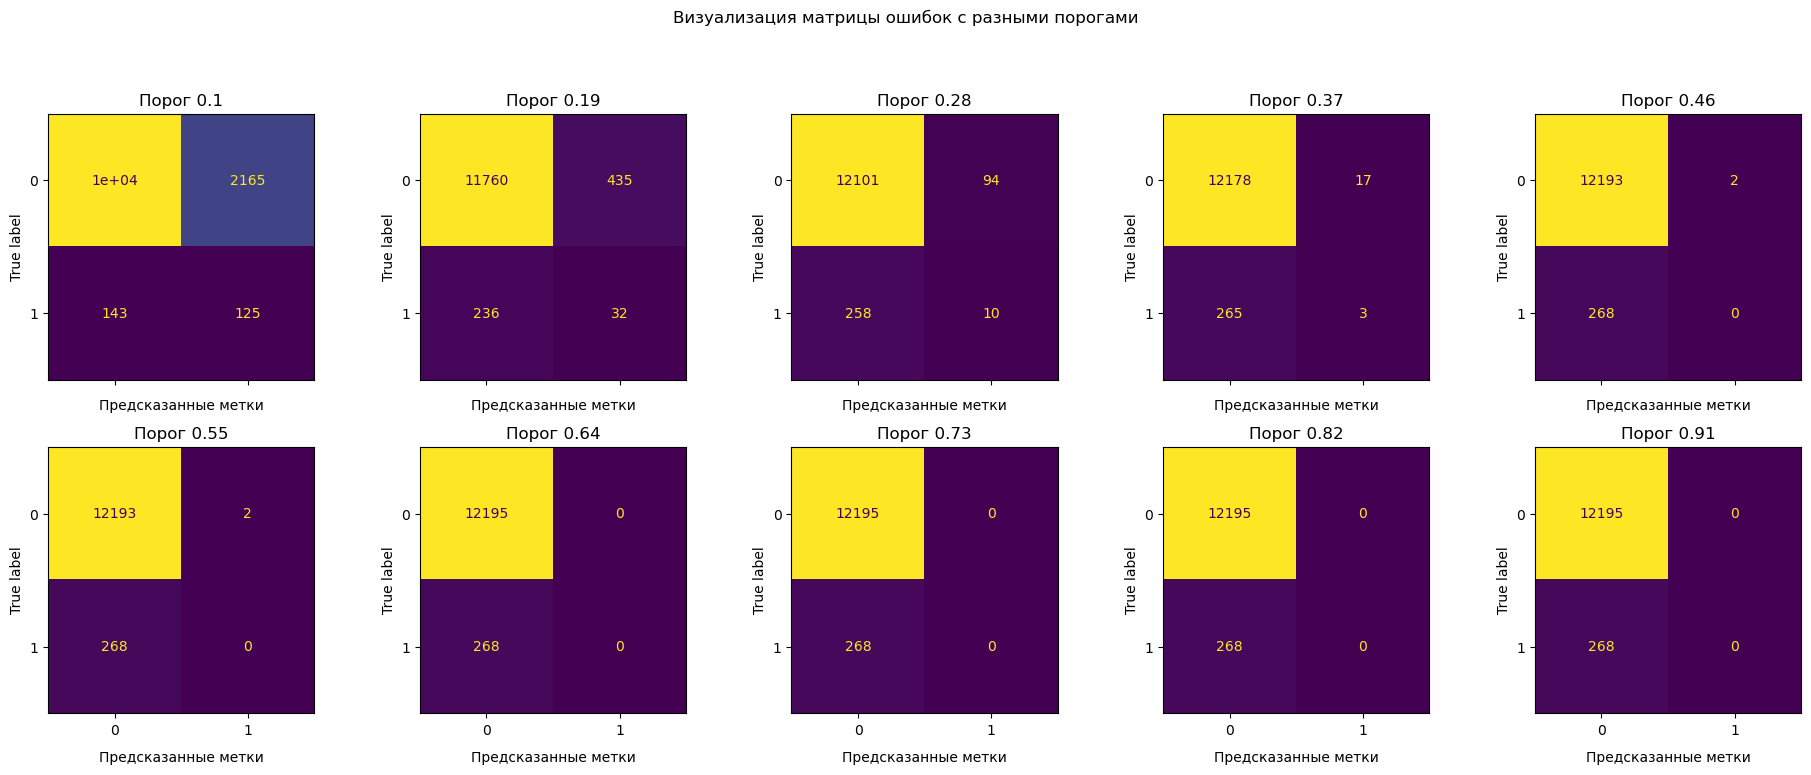

In [41]:
# Параметры порогов
thresholds = [0.1, 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91]
# Создание фигуры и сетки подграфиков
fig, axes = plt.subplots(2, 5, sharex=True, figsize=(19, 8))
fig.suptitle('Визуализация матрицы ошибок с разными порогами')

# Цикл для создания матриц ошибок
for i, threshold in enumerate(thresholds):
    # Генерируем название для графика
    title = f'Порог {threshold}'
    # Создаем матрицу ошибок
    cm = confusion_matrix(data_pre['y_test'], data_pre[f'y_pred_{threshold}'])
    # Располагаем график
    ax = axes[i // 5, i % 5]  # Разделяем на строки и колонки
    ConfusionMatrixDisplay(
        confusion_matrix=cm, 
        display_labels=best_lgbm.classes_).plot(ax=ax, colorbar=False)
    
    ax.set_title(title)
    ax.set_xlabel('Предсказанные метки', labelpad=10)  # Увеличение отступа для оси X

# Скрытие пустых подграфиков, если будет необходимо
for j in range(len(thresholds), 10):  # 10 - общее количество ячеек
    fig.delaxes(axes[j // 5, j % 5])  # Удаляем пустые графики

# Настройка отступов
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.85)  # Увеличение верхнего отступа для заголовка
plt.show()

# Итог

При подборе гиперпараметров с помощью Optuna мы получили метрику ROC-AUC 0.71

**False Negative**

При пороге 0.1 мы получаем минимальное количество FN (слева снизу) с текущей настройкой модели и подготовленными признаками – 128. Это означает, 
что модель 128 раз предсказывает, что клиент не совершит покупку, но на самом деле он это делает. Это критично, так как мы можем упустить потенциальные продажи. Например, если не предлагаем клиенту скидку или акцию, когда он собирается купить, теряем возможность увеличить доход. 

**False Positive**

С другой стороны при пороге 0.55 мы получаем минимальное количество FP (справа сверху). Это случаи, когда модель предсказывает, что клиент совершит покупку, но на самом деле этого не происходит. В контексте бизнеса это может привести к ненужным затратам на маркетинг или предложения, которые не приведут к конверсии. Например, если отправляем рекламные предложения клиентам, которые не собираются покупать, это может снизить эффективность маркетинговых усилий.